In [520]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [521]:
n_components=1
B = 0.5
y= 0.01

<b>n_components:</b> is the number of features for the new data <br>
<b>B:</b> is the similarity between the samples <br>
<b>y:</b> we use it to speceify if the class is outliers or not

In [522]:
class PCA:#impelementing PCA from scratch (previous phase)
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components = None
        self.mean = None
        

    def normalization(self,data):
        temp = deepcopy(data)
        mean = temp.mean(axis=0)
        temp = temp - mean
        self.mean= mean
        return temp
    

    def covariance(self,data):
        return np.dot(data.T,data)/len(data)

    def calc_eign(self,matrix): 
        eigen_values,eigen_vectors = get_Eigens.eig(matrix)#using custom model to calculate
        return eigen_values,eigen_vectors


    def fit(self,data):
        normalized_img = self.normalization(data)
                            
        covariance_matrix = self.covariance(normalized_img)
        eigen_values,eigen_vectors = self.calc_eign(covariance_matrix) 
        indecis = np.argsort(eigen_values)[::-1]#sorting the eigen values from the greater to the smaller
        
        eigen_vectors = eigen_vectors[indecis]#sorting the eigen vectors according to the eigen values

        self.components= eigen_vectors[:self.n_components]#take teh n_components vectors, where n_components is integer number 
    def transform(self,data):#convert the data
        temp = deepcopy(data)
        temp = temp - self.mean
        new_data = np.dot(temp,self.components.T)
        return np.array(new_data)

    def reverse(self,data):# retrieve the original data (pca sometimes cant retrieve the original data %100)
        result =np.dot(data,self.components)

        return result+self.mean

class get_Eigens():#custom class to calculate the eigen values and vectors using the principle of SVD(Singular Value Decomposition)
    def __init__(self):
        pass

    def calc_eigenvalue(self,matrix):#calculating the eigen values by firstly establishing the polynomial coefficients for the given matrix
                                     #the solving these coefficients by finding the roots of them, this gives us the eigenvalues 
        poly = np.poly(matrix)
        eigenvalues = np.roots(poly)
        return eigenvalues
    
    def calc_eigenvector(self,matrix, eigenvalues):#calculating the eigen vectors by firstly appling the equation (matrix - i*y)
                                                   # which i: is identity matrix, and y is the eigenvalue
                                                   # then applying the SVD to have a matrix (why we using that? becuase it's more stable while dealing with the floating point)
                                                   # and we faced a lot of problems without it (see phase 1 report)
                                                   # after applying the SVD we take the right singular vectors of the original matrix (vh) and from it we taking the last vector as an eigen vector for that given eigenvale

        eigenvectors = []
        idintity_matrix = np.zeros(matrix.shape);np.fill_diagonal(idintity_matrix,1)

        for eigenvalue in eigenvalues:
            _, _, vh = np.linalg.svd(matrix - eigenvalue*idintity_matrix)
            eigenvector = vh[-1]  
            eigenvector = eigenvector / np.linalg.norm(eigenvector)  # Normalize the eigenvector
            eigenvectors.append(eigenvector)

        
        return eigenvectors
    def main(self,matrix):#the main function 
        eigenvalues = self.calc_eigenvalue(matrix)
        eigenvalues = np.real(eigenvalues)
        eigenvectors =self.calc_eigenvector(matrix,eigenvalues)
        return np.array(eigenvalues),np.array(eigenvectors)
    @staticmethod
    def eig(matrix):# static function for this class to get the eigenvalues and eigenvectors without creating instance of this class
        get_eigen = get_Eigens()
        eigen_values,eigen_vectors = get_eigen.main(matrix)
        return eigen_values,eigen_vectors


In [523]:

    

class FuzzyEntropy():
    def __init__(self):
        pass
    def calc_alpha(self,s,d_dash):# this function is calculating the value of alpha from the similarity and the mean of the data
        alpha = -(np.log(s))/d_dash
        return alpha
    def Ecledian_distance(self,samples):#impelementing the ecleadian distance to get the distances matrix
        distances = []
        for i in samples:
            subdistance = []
            for j in samples:
                distance = np.sqrt(((i - j)**2).sum())
                subdistance.append(distance)
            distances.append(subdistance)
        return np.array(distances)
    
    def similarities(self,distances,alpha):# getting the similarity matrix from the distance matrix, and the variable alpha 
        similarities = np.exp(- distances* alpha)
        return np.array(similarities)
    
    def entropies(self,similarities):#calculatin the entropies for each vector and then return a list of entropies
        entropies = []
        for i in range(len(similarities)):
            i_entropy=0
            for j in range(len(similarities[i])):
                if i!=j:
                    i_entropy += (similarities[i][j]*np.log2(similarities[i][j]))+((1-similarities[i][j])*np.log2(1-similarities[i][j]))
            entropies.append(-i_entropy)
        return np.array(entropies)
    def get_next_entropy(self,sampels,entropies):#this functino is helping us to choose the coming best vector to make it the centroid of the next class
        sorted_indices = np.argsort(entropies)
        for i in range(len(sorted_indices)):
            if not sampels[sorted_indices[i]][1]:#checking if this vector belongs to a class (see the below fit function)
                return sorted_indices[i]
            
    
    def fit(self,sampels,s=0.5,y=0.1):
        distance =self.Ecledian_distance(sampels)
        d_dash = distance.mean()

        alpha = self.calc_alpha(s,d_dash)
        similarities = self.similarities(distance,alpha)
        
        entropies = self.entropies(similarities)
        selected_entropy = np.argmin(entropies)#getting the index of the best entropy(smallest) 
        
        i= 0
        sampels=[[t, False] for t in sampels]#this second index helps us to identify if this vector belongs to a class (as a centroid or in its data) or its not
        dictainary= {}#storing the class number as a key, the centroid, and the data as {class_number:{centoid_number:#, data:#}}, # are a vectors 
        outliers = []#storing the vectors that considered as outliers for the class that contains less than a pre-defined percentage number (y)

        
        while True:
            class_name = "class "+str(i)#class number

            i= i+1
            dictainary[class_name] ={
                "class_centroid": sampels[selected_entropy][0]#taking the best vector as a centorid for the current class
            }
            sampels[selected_entropy][1]= True #setting its helper value to True to mark it like taken
            data = []
            for similarity_i in range(len(similarities[selected_entropy])):
                similarity = similarities[selected_entropy][similarity_i]
                if similarity>= s and not sampels[similarity_i][1]:#checking if the the similarity between the current vector and the current centroid is greater than 'B' or not and this vector belongs to class or not
                    data.append(sampels[similarity_i][0])          
                    sampels[similarity_i][1]=True
            
            dictainary[class_name]["data"]= data
            selected_entropy = self.get_next_entropy(sampels,entropies)#choosing the best next entropy from the already calculated entropies and the original samples
            finished= True

            for t in sampels: #in this for loop wer are checking if the all samples marked as taken or not
                if not t[1]:
                   finished= False# if a single point hasnt marked as taken the loop will break and the finished variable will flagged as False
                   break

            if finished: #to check if model is finished or not
                # print("im done")
                break
        keys = [key for key,_ in dictainary.items()]# in the following few lines we are checking the size of the classes if the class dont satisifies 'y' we consider the vectors that belongs to that class as outliers
        for key in keys: 
            number_of_samples = len(dictainary[key]["data"])
            if number_of_samples/len(sampels)< y:
                outliers.append(dictainary[key]["class_centroid"])
                outliers.extend(dictainary[key]["data"])
                del dictainary[key]
        return dictainary, np.array(outliers)
            


In [524]:
dataframe = pd.read_excel("Book1.xlsx")#reading the data
data = dataframe.to_numpy()
dataframe.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [525]:
def show(info,outliers,dim):#in this function we are plotting the results of our model (classes' data and outliers) up to 3 dimensions
                            #info is a dictionary of classes recall this {class_number:{centoid_number:#, data:#}}
    if dim <=3:
        if dim ==3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')#to view the 3d figure

        for data_i in info.values():
            final_data=[data_i["class_centroid"]]
            final_data.extend(data_i["data"])
            final_data= np.array(final_data)
            if dim ==1:
                plt.scatter(range(len(final_data[:,0])),final_data[:,0])
            elif dim ==2:
                plt.scatter(final_data[:,0],final_data[:,1])
            else:
                
                x = final_data[:,0]
                y = final_data[:,1]
                z = final_data[:,2]
                ax.scatter(x, y, z, marker='o')
        if dim == 1:
            plt.scatter(range(len(outliers)), outliers, c="grey",label="outliers",marker='x')
        elif dim == 2:
            plt.scatter(outliers[:,0], outliers[:,1], c="grey",label="outliers",marker='x')
        else:
                x = outliers[:,0]
                y = outliers[:,1]
                z = outliers[:,2]
                ax.scatter(x, y, z, c="grey",label="outliers",marker='x')
        plt.legend()
        plt.show()


Reduced To:  1 , Number of Classes:  4 , Outliers:  2


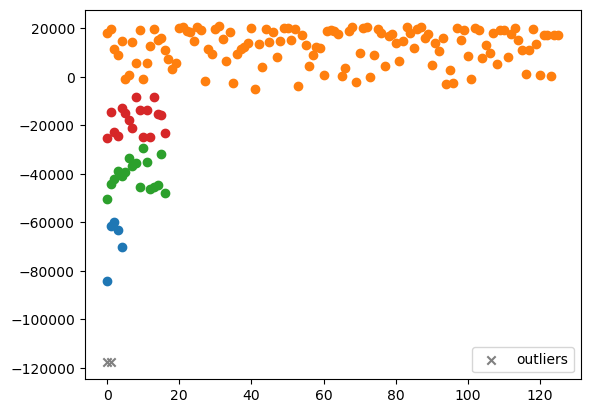

Reduced To:  2 , Number of Classes:  4 , Outliers:  4


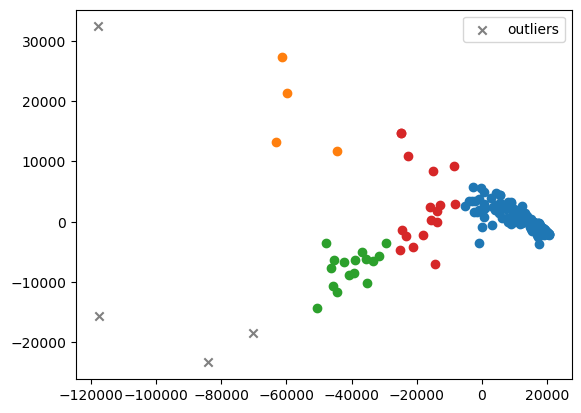

Reduced To:  3 , Number of Classes:  4 , Outliers:  4


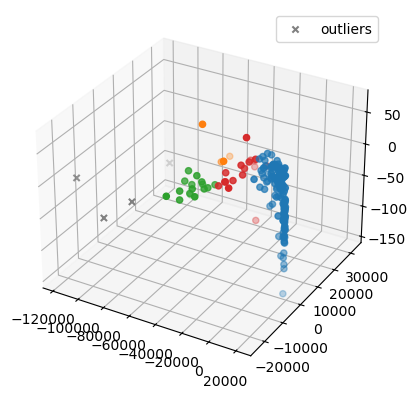

In [526]:
for t in range(3):
    pca = PCA(n_components=t+1)
    pca.fit(data)
    reduced_data = pca.transform(data)
    model = FuzzyEntropy()
    info, outliers =model.fit(reduced_data,B,y)
    print("Reduced To: ",reduced_data.shape[1],", Number of Classes: ",len(info), ", Outliers: ",len(outliers))
    f_data =show(info,outliers,dim=t+1)

